<a href="https://colab.research.google.com/github/aschelin/SimulacoesAGFE/blob/main/EquacaodePoisson2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Este tutorial é baseado no material "[CFD Python: 12 steps to Navier-Stokes](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)" de Lorena A. Barba. 

Por um momento, lembre-se das equações Navier-Stokes para um fluido incompressível, onde $\vec{{v}}$ representa o campo de velocidade:

$$
\begin{eqnarray*}
\nabla \cdot\vec{v} &=& 0 \\
\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v} &=& -\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}
\end{eqnarray*}
$$

A primeira equação representa a conservação da massa em densidade constante. A segunda equação é a conservação do momento. Mas surge um problema: a equação de continuidade do fluxo de incompressão não tem uma variável dominante e não há uma forma óbvia de acoplar a velocidade e a pressão. No caso de fluxo compressivo, em contraste, a continuidade da massa forneceria uma equação de evolução para a densidade $\rho$, que é acoplada a uma equação de estado relativa a $\rho$ e $p$.

 Uma maneira de sair desta dificuldade é *construir* um campo de pressão que garanta a continuidade; tal relação pode ser obtida tomando a divergência da equação do momento. Nesse processo, aparece uma equação de Poisson para a pressão!

Equação de Poisson 2D
----
***

A equação de Poisson é obtida pela adição de um termo fonte ao lado direito da equação de Laplace:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

Portanto, sem a equação de Laplace, há algum valor finito dentro do campo que afeta a solução. A equação de Poisson atua para "relaxar" as fontes iniciais no campo.

De forma discretizada, isto parece quase o mesmo que [Passo 9](./12_Passo_9.ipynb), exceto pelo termo fonte:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

Como antes, reordenamos isto para obter uma equação de $p$ no ponto $i,j$. Assim, obtemos:

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$


Resolveremos esta equação assumindo um estado inicial de $p=0$ em todos os lugares e aplicando as condições de fronteira da seguinte forma:

$p=0$ em $x=0, \ 2$ e $y=0, \ 1$

e o termo fonte consiste em dois picos iniciais dentro do domínio, como se segue:

$b_{i,j}=100$ em $i=\frac{1}{4}nx, j=\frac{1}{4}ny$

$b_{i,j}=-100$ em $i=\frac{3}{4}nx, j=\frac{3}{4}ny$

$b_{i,j}=0$ em todos os outros lugares.

As iterações avançarão em pseudotempo para relaxar os picos iniciais. O relaxamento sob a equação de Poisson vai ficando cada vez mais lento à medida que eles avançam. *Por quê?

Vejamos uma maneira possível de escrever o código para a equação de Poisson. Como sempre, carregamos nossas bibliotecas favoritas de Python. Também queremos fazer alguns belos gráficos em 3D. Vamos definir nossos parâmetros. O que você observa da abordagem abaixo?

In [2]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
# Parameters
nx = 50
ny = 50
nt  = 100
xmin = 0
xmax = 2
ymin = 0
ymax = 1

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

# Initialization
p  = numpy.zeros((ny, nx))
pd = numpy.zeros((ny, nx))
b  = numpy.zeros((ny, nx))
x  = numpy.linspace(xmin, xmax, nx)
y  = numpy.linspace(xmin, xmax, ny)

# Source
b[int(ny / 4), int(nx / 4)]  = 100
b[int(3 * ny / 4), int(3 * nx / 4)] = -100

Com isso, estamos prontos para avançar o palpite inicial em pseudotempo. Como o código abaixo é diferente da função utilizada anteriormente para resolver a equação de Laplace?

In [4]:
for it in range(nt):

    pd = p.copy()

    p[1:-1,1:-1] = (((pd[1:-1, 2:] + pd[1:-1, :-2]) * dy**2 +
                    (pd[2:, 1:-1] + pd[:-2, 1:-1]) * dx**2 -
                    b[1:-1, 1:-1] * dx**2 * dy**2) / 
                    (2 * (dx**2 + dy**2)))

    p[0, :] = 0
    p[ny-1, :] = 0
    p[:, 0] = 0
    p[:, nx-1] = 0

Reutilizando a função plod2D:

In [1]:
def plot2D(x, y, p):
    fig = pyplot.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    X, Y = numpy.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')


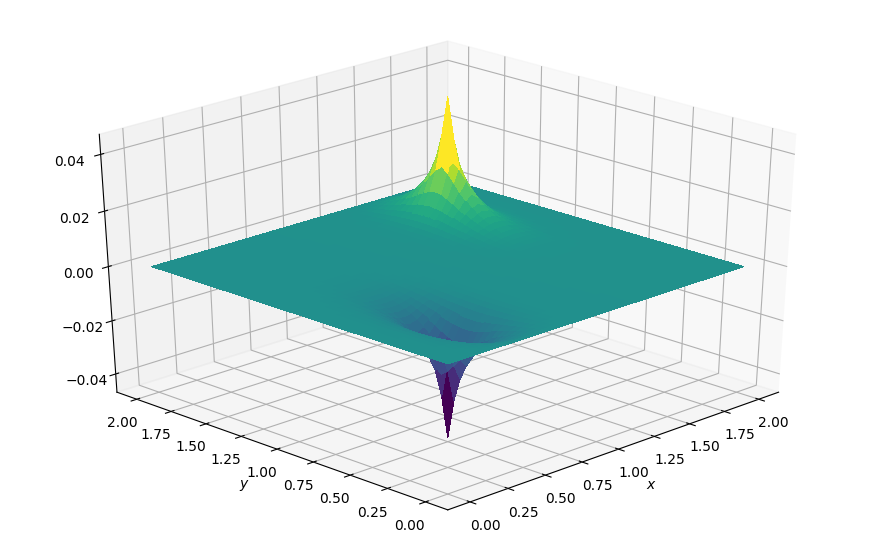

In [5]:
plot2D(x, y, p)